### Etymology Prefix Suffix Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import re
from kneed import KneeLocator
from pathlib import Path
import shutil

In [2]:
# language pair
lang_folder = "Dutch"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
lang_pair = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# pre-suffix select
prefix = True  # True, False  word is prefix  example: prefix = True and suffix = False for Turkish word
suffix = False # True, False  word is suffix

# native word select
word_analysis = False  # True, False  Not: True for native word analysis, False for etymological word analysis
word_num = 28

In [3]:
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}").mkdir(parents=True, exist_ok=True)
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}").mkdir(parents=True, exist_ok=True)

In [4]:
def detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False):
    '''
    default parameter:\n
    detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False)\n
    detect_prefix_suffix_word(df, "word", ["abacus","aba","su"], prefix=True, suffix=True)\n
    df is dataframe. Each word of word_ety_list search in df_column according to prefix_word and suffix_word condition.\n
    prefix_word and suffix_word are not extention. they represents location of word of word_ety_list (word before or after)
    '''    
    df_ety_prefix_suffix_word_result = pd.DataFrame()
    for i in word_ety_list:
        # suffix result
        if suffix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"{i}(?:$)", na=True)]  # string+ext=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass
        # prefix result
        if prefix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"(?:^){i}", na=True)]  # ext+string=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass    
        
    #df_ety_suffix_word_result = df_word_result.sort_values(by="frequency", ascending=False)
    df_ety_prefix_suffix_word_result.drop_duplicates(inplace=True)
    df_ety_prefix_suffix_word_result.reset_index(drop=True, inplace=True)

    return df_ety_prefix_suffix_word_result 

In [5]:
def exract_prefix_suffix(df, source_column, target_column):
    '''
    exract_prefix_suffix(df, source_column, target_column):\n
    exract_prefix_suffix(df, "word_pair", "word"):\n
    df is dataframe. word of source_column search in target_column\n
    and exract prefix or suffix. 
    '''
    for i in range(len(df)):
        source_word = df.loc[i,f"{source_column}"]
        target_word = df.loc[i,f"{target_column}"]
        try:
            search_loc = re.search(fr"{source_word}", target_word, re.UNICODE|re.IGNORECASE)
            search_loc_start = search_loc.span()[0]
            search_loc_end = search_loc.span()[1]
            if search_loc_start > 0:
                var1= target_word[0:search_loc_start]
                prefix_suffix = f"{var1}+"
                df.loc[i,"prefix_suffix"] = prefix_suffix                
            else:
                var2 = target_word[search_loc_end:]
                prefix_suffix = f"+{var2}" 
                df.loc[i,"prefix_suffix"] = prefix_suffix 
        except:
            pass
    return df

##### Prefix Suffix All

In [6]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

,word,frequency
0,ik,22539531
1,je,20769946
2,het,15696161
3,de,15258816
4,dat,13387137
...,...,...
331836,polygamisch,5
331837,shiit,5
331838,ambient,5
331839,zinswendingen,5


In [7]:
if word_analysis:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
    df_pair = df_pair.head(word_num)
    df_pair.rename(columns={"word":"dict_entry_main"}, inplace=True)
else:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}/{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Vocabulary.xlsx")
df_pair

,dict_entry_main,frequency
0,ik,22539531
1,je,20769946
2,het,15696161
3,de,15258816
4,dat,13387137
5,is,12813896
6,een,11124670
7,niet,10747590
8,en,8257870
9,van,6532887


In [8]:
word_ety_list = df_pair["dict_entry_main"].values.tolist()
#word_ety_list

In [9]:
df_prefix_suffix_word = detect_prefix_suffix_word(df_word_all, "word", word_ety_list, prefix_word=prefix, suffix_word=suffix)
df_prefix_suffix_word

,search_word,word,frequency
0,ik,ik,22539531
1,ik,ikzelf,3730
2,ik,ike,2586
3,ik,ikje,2099
4,ik,ikik,1925
...,...,...,...
39958,was,wastafeltje,5
39959,was,wasschacht,5
39960,was,waswellichtcommissaris,5
39961,was,waszakken,5


In [10]:
df_prefix_suffix = exract_prefix_suffix(df_prefix_suffix_word, "search_word", "word")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,ik,ik,22539531,+
1,ik,ikzelf,3730,+zelf
2,ik,ike,2586,+e
3,ik,ikje,2099,+je
4,ik,ikik,1925,+ik
...,...,...,...,...
39958,was,wastafeltje,5,+tafeltje
39959,was,wasschacht,5,+schacht
39960,was,waswellichtcommissaris,5,+wellichtcommissaris
39961,was,waszakken,5,+zakken


In [11]:
df_prefix_suffix.search_word.nunique()

28

In [12]:
df_prefix_suffix.word.nunique()

39279

In [13]:
if word_analysis:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_All.xlsx", index=False)
else:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx", index=False)

##### Select From Length

In [14]:
if word_analysis:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_All.xlsx")
else:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,ik,ik,22539531,+
1,ik,ikzelf,3730,+zelf
2,ik,ike,2586,+e
3,ik,ikje,2099,+je
4,ik,ikik,1925,+ik
...,...,...,...,...
39958,was,wastafeltje,5,+tafeltje
39959,was,wasschacht,5,+schacht
39960,was,waswellichtcommissaris,5,+wellichtcommissaris
39961,was,waszakken,5,+zakken


In [15]:
df_prefix_suffix["prefix_suffix_len"] = df_prefix_suffix["prefix_suffix"].apply(lambda x: (len(x)-1))
df_prefix_suffix

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,ik,ik,22539531,+,0
1,ik,ikzelf,3730,+zelf,4
2,ik,ike,2586,+e,1
3,ik,ikje,2099,+je,2
4,ik,ikik,1925,+ik,2
...,...,...,...,...,...
39958,was,wastafeltje,5,+tafeltje,8
39959,was,wasschacht,5,+schacht,7
39960,was,waswellichtcommissaris,5,+wellichtcommissaris,19
39961,was,waszakken,5,+zakken,6


In [16]:
prefix_suffix_mean = int(round(df_prefix_suffix["prefix_suffix_len"].mean(),0))
prefix_suffix_mean

8

In [17]:
df_prefix_suffix_select = df_prefix_suffix[df_prefix_suffix["prefix_suffix"].str.len() <= prefix_suffix_mean]
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,ik,ik,22539531,+,0
1,ik,ikzelf,3730,+zelf,4
2,ik,ike,2586,+e,1
3,ik,ikje,2099,+je,2
4,ik,ikik,1925,+ik,2
...,...,...,...,...,...
39955,was,wasjaren,5,+jaren,5
39956,was,wastoch,5,+toch,4
39959,was,wasschacht,5,+schacht,7
39961,was,waszakken,5,+zakken,6


In [18]:
if word_analysis:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Select.xlsx", index=False)
else:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx", index=False)

##### Select With Prefix Suffix

In [19]:
if word_analysis:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Select.xlsx")
else:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx")
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,ik,ik,22539531,+,0
1,ik,ikzelf,3730,+zelf,4
2,ik,ike,2586,+e,1
3,ik,ikje,2099,+je,2
4,ik,ikik,1925,+ik,2
...,...,...,...,...,...
21822,was,wasjaren,5,+jaren,5
21823,was,wastoch,5,+toch,4
21824,was,wasschacht,5,+schacht,7
21825,was,waszakken,5,+zakken,6


In [20]:
df_prefix_suffix_freq = df_prefix_suffix_select[["prefix_suffix"]].value_counts().reset_index()
df_prefix_suffix_freq.rename(columns={0:"frequency"}, inplace=True)
df_prefix_suffix_freq

,prefix_suffix,frequency
0,+,28
1,+s,26
2,+een,24
3,+en,24
4,+t,24
...,...,...
17504,+hangend,1
17505,+hanging,1
17506,+hangir,1
17507,+hangt,1


In [21]:
prefix_suffix_freq_sum = df_prefix_suffix_freq.loc[:,"frequency"].sum()
prefix_suffix_freq_sum

21827

In [22]:
df_prefix_suffix_freq["ratio"] = round(((df_prefix_suffix_freq.loc[:,"frequency"]/prefix_suffix_freq_sum)*100),7)
df_prefix_suffix_freq


,prefix_suffix,frequency,ratio
0,+,28,0.128281
1,+s,26,0.119119
2,+een,24,0.109956
3,+en,24,0.109956
4,+t,24,0.109956
...,...,...,...
17504,+hangend,1,0.004581
17505,+hanging,1,0.004581
17506,+hangir,1,0.004581
17507,+hangt,1,0.004581


In [23]:
df_prefix_suffix_freq["cumul_ratio"] = np.cumsum(df_prefix_suffix_freq["ratio"])
df_prefix_suffix_freq

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,28,0.128281,0.128281
1,+s,26,0.119119,0.247400
2,+een,24,0.109956,0.357356
3,+en,24,0.109956,0.467311
4,+t,24,0.109956,0.577267
...,...,...,...,...
17504,+hangend,1,0.004581,99.981986
17505,+hanging,1,0.004581,99.986568
17506,+hangir,1,0.004581,99.991149
17507,+hangt,1,0.004581,99.995731


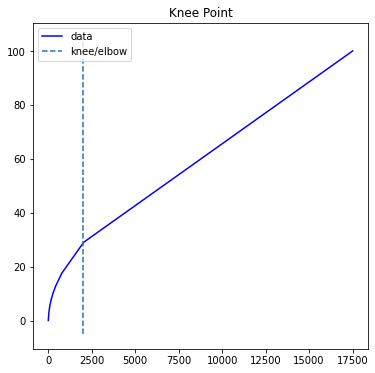

In [24]:
prefix_suffix_kneedle = KneeLocator(x=df_prefix_suffix_freq.cumul_ratio.index, y=df_prefix_suffix_freq.cumul_ratio, S=1.0, curve="concave", direction="increasing")
prefix_suffix_kneedle.plot_knee()

In [25]:
knee_point_prefix_suffix = round(prefix_suffix_kneedle.knee_y)
knee_point_prefix_suffix

29

In [26]:
df_prefix_suffix_knee = df_prefix_suffix_freq[df_prefix_suffix_freq.cumul_ratio <= knee_point_prefix_suffix]
df_prefix_suffix_knee

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,28,0.128281,0.128281
1,+s,26,0.119119,0.247400
2,+een,24,0.109956,0.357356
3,+en,24,0.109956,0.467311
4,+t,24,0.109956,0.577267
...,...,...,...,...
2012,+bb,2,0.009163,28.959573
2013,+aya,2,0.009163,28.968736
2014,+ani,2,0.009163,28.977899
2015,+aha,2,0.009163,28.987062


In [27]:
prefix_suffix_list = df_prefix_suffix_knee["prefix_suffix"].to_list()

In [28]:
disable_prefix_suffix_list = ["+anityi","+bidir","+workun","+düktörlere","+rysin","+ein","+ei","+x","+ren","+hul"]

In [29]:
set_prefix_suffix = set(prefix_suffix_list)
set_disable_prefix_suffix = set(disable_prefix_suffix_list)

In [30]:
prefix_suffix_custom_list = list(set_prefix_suffix.difference(set_disable_prefix_suffix))

In [31]:
df_prefix_suffix_custom = pd.DataFrame()
for i in prefix_suffix_custom_list:
    df_var = df_prefix_suffix[df_prefix_suffix["prefix_suffix"] == f"{i}"]
    df_prefix_suffix_custom = pd.concat([df_prefix_suffix_custom, df_var], axis=0)
df_prefix_suffix_custom.sort_values(by="word", inplace=True)
df_prefix_suffix_custom.reset_index(drop=True, inplace=True)
df_prefix_suffix_custom

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,als,als,3780131,+,0
1,als,alsa,6,+a,1
2,als,alsaha,8,+aha,3
3,als,alsals,79,+als,3
4,als,alsatia,8,+atia,4
...,...,...,...,...,...
6310,zijn,zijnvader,5,+vader,5
6311,zijn,zijnvan,10,+van,3
6312,zijn,zijnwe,13,+we,2
6313,zijn,zijnze,29,+ze,2


In [32]:
df_frequency_mean = df_prefix_suffix_custom.groupby(["search_word"])[["frequency"]].mean()
df_frequency_mean.reset_index(inplace=True)
df_frequency_mean.rename(columns={"frequency":"frequency_mean"}, inplace=True)
df_frequency_mean

,search_word,frequency_mean
0,als,113988.971429
1,dat,135986.656566
2,de,36193.127135
3,die,54493.802469
4,een,139449.425287
5,en,43070.628019
6,er,28751.388393
7,heb,146329.823529
8,het,168692.968085
9,hij,112406.108696


In [33]:
df_prefix_suffix_freq_mean = pd.merge(df_prefix_suffix_custom, df_frequency_mean, how="inner", on="search_word")
df_prefix_suffix_freq_mean

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,als,als,3780131,+,0,113988.971429
1,als,alsa,6,+a,1,113988.971429
2,als,alsaha,8,+aha,3,113988.971429
3,als,alsals,79,+als,3,113988.971429
4,als,alsatia,8,+atia,4,113988.971429
...,...,...,...,...,...,...
6310,zijn,zijnvader,5,+vader,5,128147.000000
6311,zijn,zijnvan,10,+van,3,128147.000000
6312,zijn,zijnwe,13,+we,2,128147.000000
6313,zijn,zijnze,29,+ze,2,128147.000000


In [34]:
df_prefix_suffix_freq_mean_select = df_prefix_suffix_freq_mean[(df_prefix_suffix_freq_mean.frequency >= df_prefix_suffix_freq_mean.frequency_mean)]
df_prefix_suffix_freq_mean_select.reset_index(drop=True, inplace=True)
df_prefix_suffix_freq_mean_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,als,als,3780131,+,0,113988.971429
1,als,alsof,201522,+of,2,113988.971429
2,dat,dat,13387137,+,0,135986.656566
3,de,de,15258816,+,0,36193.127135
4,de,deal,47765,+al,2,36193.127135
...,...,...,...,...,...,...
177,ze,zes,117116,+s,1,31190.308772
178,ze,zet,165887,+t,1,31190.308772
179,ze,zetten,93444,+tten,4,31190.308772
180,ze,zeven,67505,+ven,3,31190.308772


In [35]:
df_prefix_suffix_freq_mean_select.search_word.nunique()

28

In [36]:
df_prefix_suffix_freq_mean_select.word.nunique()

177

In [37]:
if word_analysis:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)
else:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)

##### Copy Move And Delete

In [38]:
output_file1 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*Result.xlsx")
output_file1

['Dutch_Turkish_28_Word_Prefix_Suffix_Custom_Result.xlsx']

In [39]:
for k in output_file1:
    source = k # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}"
    shutil.copy2(source, destination)

In [40]:
for i in output_file1:
    try:
        os.remove(i)
    except:
        pass

In [41]:
output_file2 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*.xlsx")
output_file2

['Dutch_Turkish_28_Word_Prefix_Suffix_All.xlsx',
 'Dutch_Turkish_28_Word_Prefix_Suffix_Select.xlsx']

In [42]:
for l in output_file2:
    source = l # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}"
    shutil.copy2(source, destination)

In [43]:
for j in output_file2:
    try:
        os.remove(j)
    except:
        pass